In [ ]:
import gc
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from typing import Tuple
from tqdm import tqdm

In [ ]:
from transformers import (TFGPT2Model,TFMBartModel,TFBertForSequenceClassification,
                         TFDistilBertForSequenceClassification,TFXLMRobertaForSequenceClassification,
                         TFMT5ForConditionalGeneration,TFT5ForConditionalGeneration,T5Tokenizer,AutoTokenizer,AutoConfig)

In [ ]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

def set_seeds(seed:int)->None:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

MAX_LEN = 512
TEST_SIZE = 0.2
LR = 0.00002
VERBOSE = 1
SEED = 1000
set_seeds(SEED)

AUTOTUNE = tf.data.experimental.AUTOTUNE

BASE_BATCH_SIZE = 4

if tpu is not None:
    BASE_BATCH_SIZE = 8

BATCH_SIZE = BASE_BATCH_SIZE+strategy.num_replicas_in_sync

In [ ]:
df = pd.read_csv('data.csv', on_bad_lines = 'warn',index_col=False, encoding='iso-8859-1', nrows=1000)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


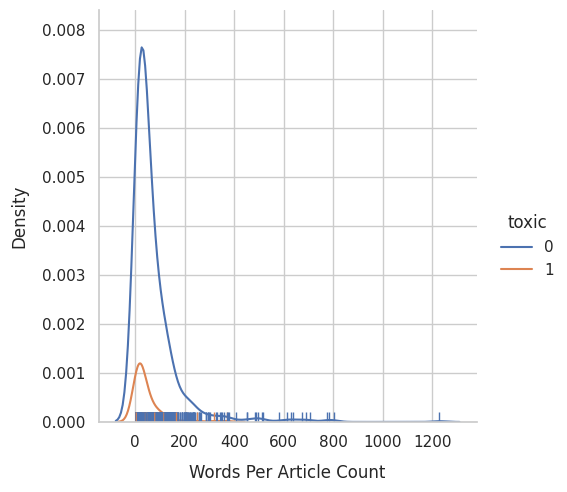

In [ ]:
sns.set_theme(style='whitegrid')

df['text_wordcount'] = df.comment_text.str.split(' ').str.len()

displot = sns.displot(df,kind='kde',rug=True, x='text_wordcount',hue='toxic')
displot.set_axis_labels('Words Per Article Count','Density',labelpad=10)
plt.show()

In [ ]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, val_df = train_test_split(df,
                                    test_size = TEST_SIZE,
                                    random_state = SEED)

In [ ]:
def create_dataset(df, max_len, tokenizer, batch_size, shuffle=False):
    total_samples = df.shape[0]

    # Placeholders for inputs
    input_ids, input_masks = [], []

    # Placeholder for output labels
    labels = []

    # Tokenize
    for _, row in tqdm(df.iterrows(), total=total_samples):

        # Get comment text
        comment_text = row['comment_text']

        # Encode
        input_encoded = tokenizer.encode_plus(comment_text, add_special_tokens=True, max_length=max_len, truncation=True, padding='max_length')
        input_ids.append(input_encoded['input_ids'])
        input_masks.append(input_encoded['attention_mask'])

        # Determine label
        # Here, assuming 'toxic' column represents any form of toxicity
        toxic_labels = [row['toxic'], row['severe_toxic'], row['obscene'], row['threat'], row['insult'], row['identity_hate']]
        label = 1 if any(toxic_labels) else 0
        labels.append(label)

    # Convert lists to numpy arrays
    input_ids = np.array(input_ids)
    input_masks = np.array(input_masks)
    labels = np.array(labels, dtype=np.int32)

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': input_ids, 'attention_mask': input_masks},
        labels
    ))

    # Shuffle dataset if required
    if shuffle:
        dataset = dataset.shuffle(total_samples, reshuffle_each_iteration=True)

    # Batch and prefetch dataset
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset


In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoConfig, AutoTokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import tensorflow as tf
import gc

EPOCHS = 3
model_type = 'bert-base-multilingual-cased'
LR = 0.001

config = AutoConfig.from_pretrained(model_type, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_type, add_prefix_space=False, do_lower_case=False)

train_dataset = create_dataset(train_df, MAX_LEN, tokenizer, BATCH_SIZE)
validation_dataset = create_dataset(val_df, MAX_LEN, tokenizer, BATCH_SIZE)

train_steps = train_df.shape[0] // BATCH_SIZE
val_steps = val_df.shape[0] // BATCH_SIZE

print(f'Train Steps: {train_steps}')
print(f'Validation Steps: {val_steps}')

def create_mbert_model(model_type, config, learning_rate):
    model = TFAutoModelForSequenceClassification.from_pretrained(model_type, config=config)

    optimizer = Adam(learning_rate=learning_rate)
    loss = SparseCategoricalCrossentropy(from_logits=True)
    metric = SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer='adam', loss=loss, metrics=[metric])

    return model

model = create_mbert_model(model_type, config, LR)
print(model.summary())

history = model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=validation_dataset,
                    validation_steps=val_steps, epochs=EPOCHS, verbose=1)


100%|██████████| 200/200 [00:00<00:00, 1083.42it/s]


Train Steps: 160
Validation Steps: 40


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 177854978 (678.46 MB)
Trainable params: 177854978 (678.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
160/160 [==============================] - 5496s 34s/step - loss: 0.4182 - accuracy: 0.8607 - val_loss: 0.2548 - val_accuracy: 0.8864
Epoch 2/3
160/160 [==============================] - 5197s 32s/step - loss: 0.4113 - accuracy: 0.8857 - val_loss: 0.2556 - val_accuracy: 0.8894
Epoch 3/3
160/160 [==============================] - 5148s 32s/step - loss: 0.4131 - accuracy: 0.8883 - val_loss: 0.2538 - val_accuracy: 0.8903


In [ ]:
  print(f'MultiLingual BERT Classification Model Accuracy: {np.max(history.history["val_accuracy"])*100:.3f}%')